# Density estimation
_________
###  Table of content

[1. Data](#data)<br>
[2. Histogram density estimation](#histogram)<br>
[3. Empirical cumulative distribution function](#ecdf)<br>
[4. Kernel density estimation](#kernel)<br>
[5. Switching Model Regression](#switching)<br>
_________

### Importations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors.kde import KernelDensity

<a id='data'></a>
# Data

In [2]:
df_rwanda = pd.read_csv('./data/rwanda')

X = df_rwanda['mean_light']
y = df_rwanda['wealth_index']

X = np.resize(X, (X.shape[0], 1))
y = np.resize(y, (y.shape[0], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Data is splited into 3 parts, by comparaison of the mean_light variable to the separator value :
 - values equal to 0 : X_0 and y_0
 - values between 0 and the separator : X_low and y_low
 - values higher than the separator : X_high and y_high

In [3]:
sep = 3

X_low, y_low, X_high, y_high, X_0, y_0 = [], [], [], [], [], []
for i in range(X.shape[0]):
    if X[i][0] == 0:
        X_0.append(X[i])
        y_0.append(y[i])
    elif X[i][0] <= sep:
        X_low.append(X[i])
        y_low.append(y[i])
    else:
        X_high.append(X[i])
        y_high.append(y[i])
        
X_0 = np.resize(X_0, (len(X_0), 1))
y_0 = np.resize(y_0, (len(y_0), 1))
X_low = np.resize(X_low, (len(X_low), 1))
y_low = np.resize(y_low, (len(y_low), 1))
X_high = np.resize(X_high, (len(X_high), 1))
y_high = np.resize(y_high, (len(y_high), 1))

### Data visualization

#### All data

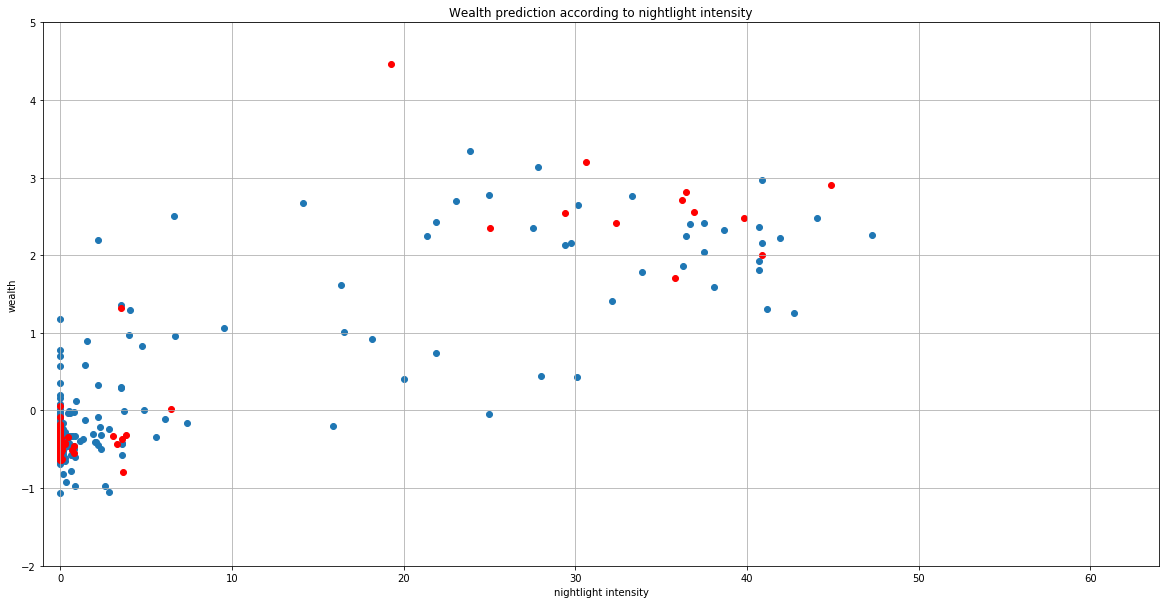

In [4]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlim(-1, 64)
plt.ylim(-2, 5)
plt.title('Wealth prediction according to nightlight intensity')
plt.xlabel('nightlight intensity')
plt.ylabel('wealth')
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test, color='r')
plt.show()

#### Values equal to 0

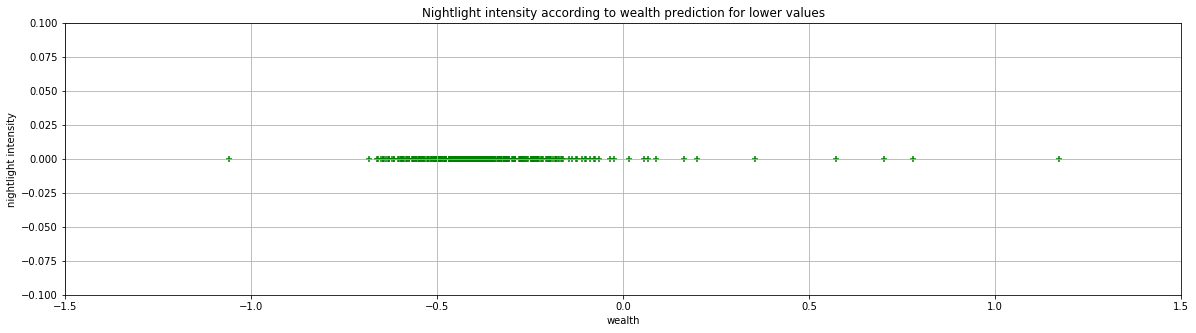

In [5]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.xlim(-1.5, 1.5)
plt.ylim(-0.1, 0.1)
plt.title('Nightlight intensity according to wealth prediction for lower values')
plt.ylabel('nightlight intensity')
plt.xlabel('wealth')
plt.scatter(y_0, X_0, color='g', marker='+')
plt.show()

#### Lower values

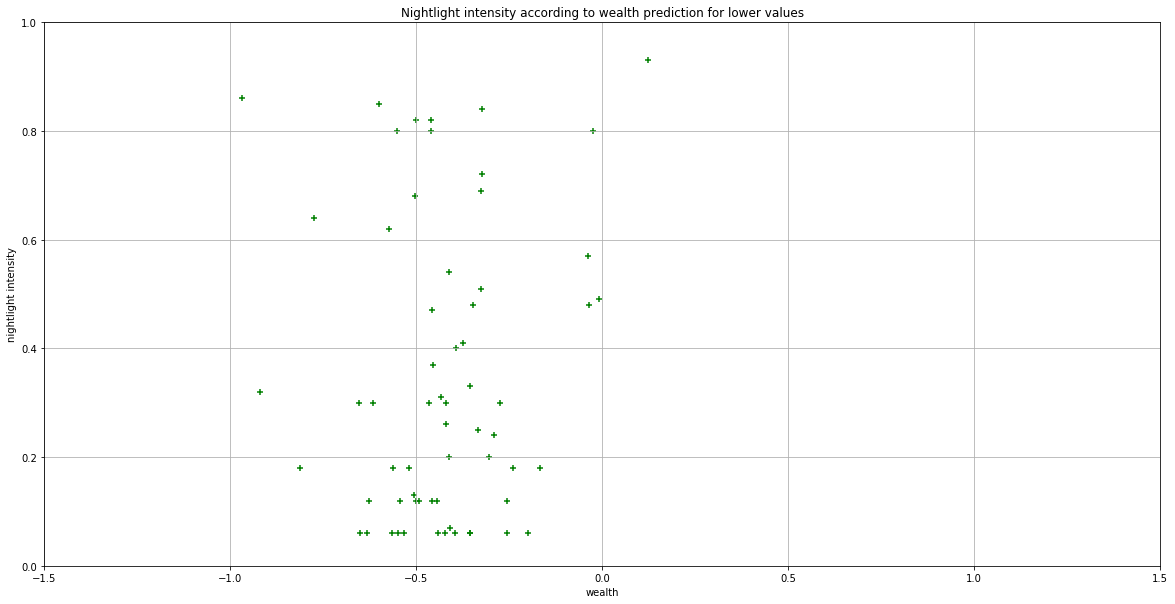

In [6]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlim(-1.5, 1.5)
plt.ylim(0, 1)
plt.title('Nightlight intensity according to wealth prediction for lower values')
plt.ylabel('nightlight intensity')
plt.xlabel('wealth')
plt.scatter(y_low, X_low, color='g', marker='+')
plt.show()

#### Higher values

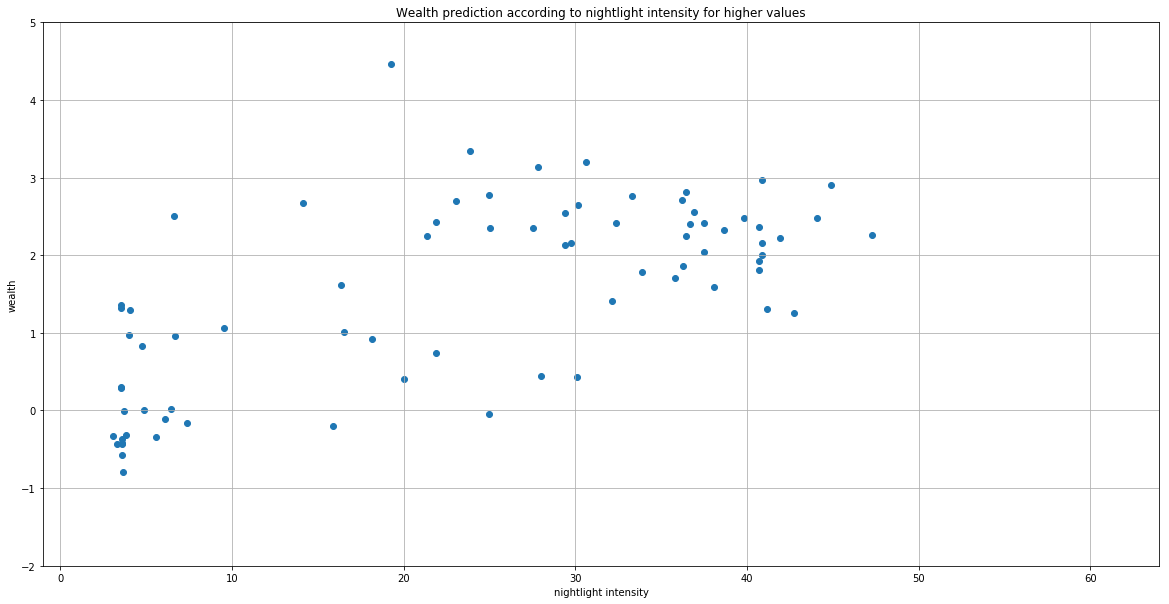

In [7]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlim(-1, 64)
plt.ylim(-2, 5)
plt.title('Wealth prediction according to nightlight intensity for higher values')
plt.xlabel('nightlight intensity')
plt.ylabel('wealth')
plt.scatter(X_high, y_high)
plt.show()

#### Sizes

In [8]:
print("X_0 : " + str(np.shape(X_0)))
print("X_low : " + str(np.shape(X_low)))
print("X_high : " + str(np.shape(X_high)))

X_0 : (335, 1)
X_low : (81, 1)
X_high : (76, 1)


<a id='histogram'></a>
# Histogram Density Estimation

A density model is a density function estimation model which requires low computer performance. Histogram density estimation is the easiest among those models.

## a) Definition
Let's write the observations as $(X_1,...,X_n)$ iid random variables with $f$ as their density function, and let's define $(C_1,...,C_m)$ a partition of $[0, 1[$ as :

$$ C_j = [{ \frac{j-1}{m},\frac{j}{m} }[,  j=1,...,m.$$

As $f$ is continue, it can be approched by constant step functions over the intervals $(C_j)$. By writing $h=1/m$, the estimator is :

$$ \bar{f_h}(x) = \sum_{j=1}^{m} \frac{p_j}{h} \mathbb{1}_{C_j}(x),$$

where $p_j=\int_{C_j} f(x)dx$. The estimation problem is now to estimate the parameter $p=(p_1,...,p_m)$. This is solved by using a method of moments :

$$p_j=\int_{C_j} f(x)dx=\mathbb{E}_f[\mathbb{1}_{C_j}(X_1)],j=1,...,m.$$

$p$ can be estimated by using :

$$\hat{p_j}=\frac{1}{n}\sum_{i=1}^{n}\mathbb{1}_{C_j}(X_i).$$

Each $\hat{p_j}$ represents the **proportion** of $X_i$ that $C_j$ contains. Finally, the **estimator** is :

$$ \hat{f_h}(x)=\frac{1}{h}\sum_{j=1}^{m} \hat{p_j}\mathbb{1}_{C_j}(x). $$

$C_j$ is called a **class** and h a **window**.

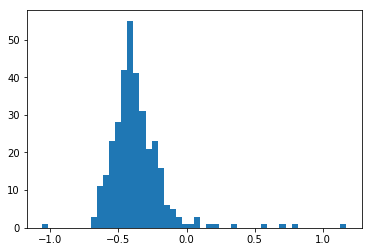

In [9]:
# TODO subplot des 3 histogrammes

b = 50
res = plt.hist(y_0, bins=b)
out = res[0] / y_0.shape[0]

## b) Window optimisation

TODO

In order to minimize the Mean Square Error ...

In [10]:
# TODO optimisation de la fenetre

In [11]:
# TODO subplot nouveaux histogrammes avec la nouvelle fenetre

<a id='ecdf'></a>
# Empirical cumulative distribution function

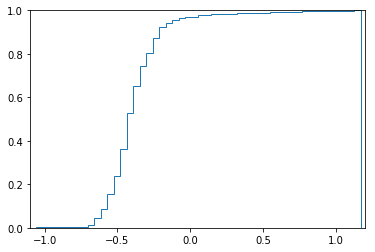

In [12]:
# TODO subplots

n, bins, patches = plt.hist(y_0, bins=b, density=True, histtype='step', cumulative=True)
plt.xlim(-1.1, 1.2)
plt.ylim(0, 1)
plt.show()

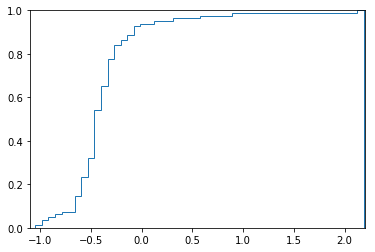

In [13]:
n, bins, patches = plt.hist(y_low, bins=b, density=True, histtype='step', cumulative=True)
plt.xlim(-1.1, 2.2)
plt.ylim(0, 1)
plt.show()

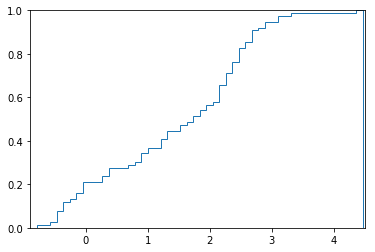

In [14]:
n, bins, patches = plt.hist(y_high, bins=b, density=True, histtype='step', cumulative=True)
plt.xlim(-0.9, 4.5)
plt.ylim(0, 1)
plt.show()

We can use a Kolmogorov-Smirnov test to compare the ECDF with an estimator of the real density function.

In [15]:
# TODO np.random.choice pour sample depuis un histogramme et tester MSE

<a id='kernel'></a>
# Kernel Density Estimation

TODO théorie

In [16]:
def kdegraph(kernel_type, distribution=False):
    kde = KernelDensity(kernel=kernel_type, bandwidth=0.2).fit(y_0)
    plt.figure(figsize=(20, 10))
    plt.grid()
    plt.xlim(-1.5, 2.2)
    plt.title('Kernel Density Estimation with ' + kernel_type + ' kernel')
    plt.scatter(y_0, kde.score_samples(y_0), color='g', marker='+')
    plt.show()
    if distribution:
        plt.hist(y_0, bins=b, color='r', density=True, histtype='step', cumulative=True)
        plt.hist(kde.sample(np.shape(y_0)[0]), bins=b, density=True, histtype='step', cumulative=True)
        plt.show()


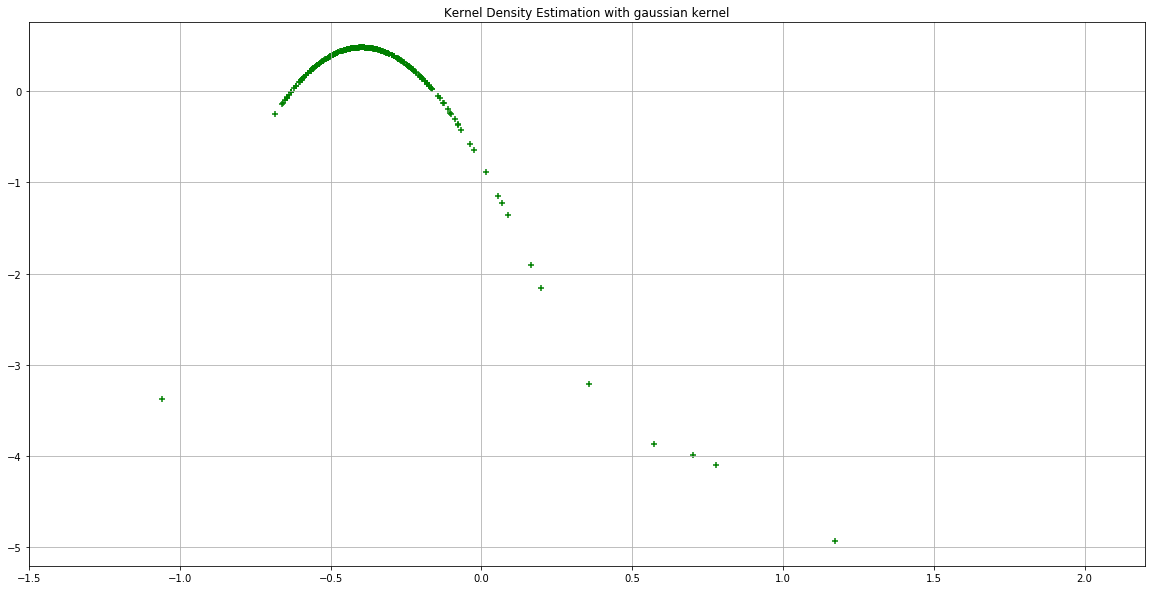

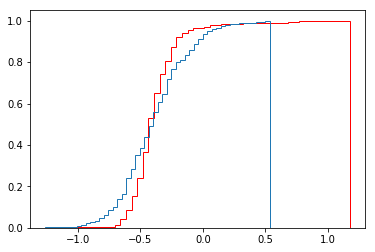

In [17]:
kdegraph('gaussian', distribution=True)

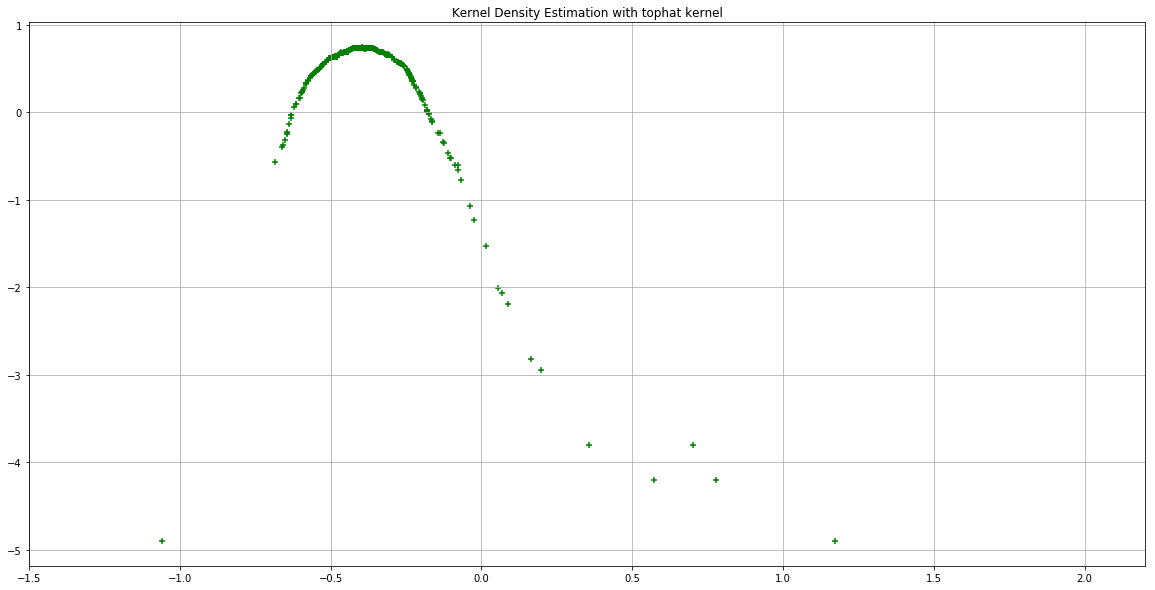

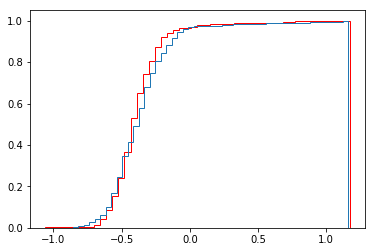

In [18]:
kdegraph('tophat', distribution=True)

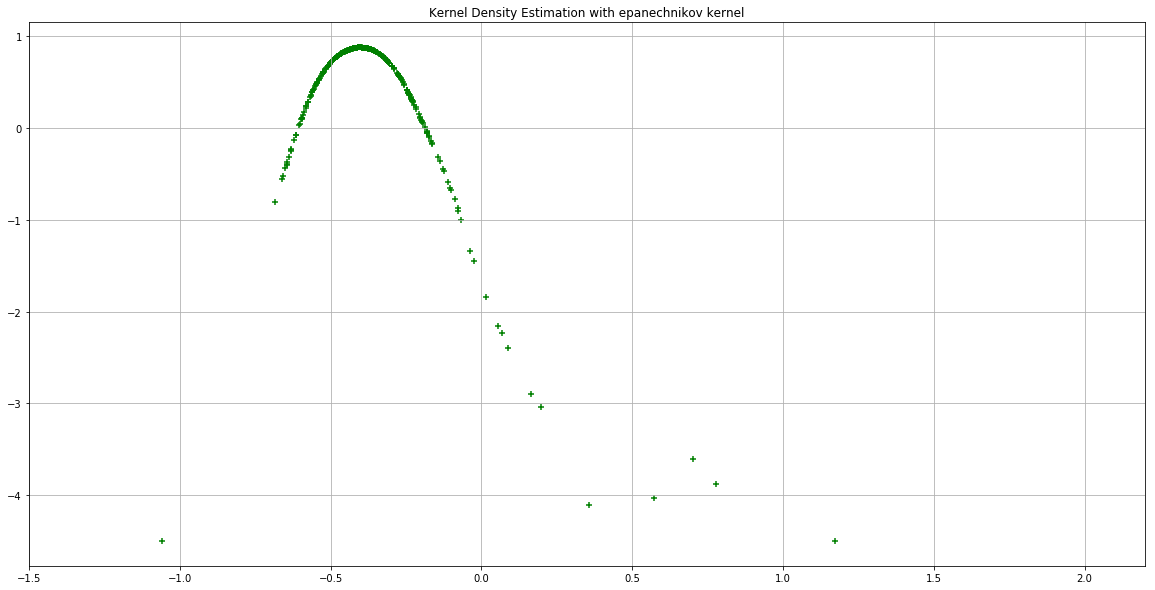

In [19]:
# TODO subplot avec les 4 derniers




kdegraph('epanechnikov')

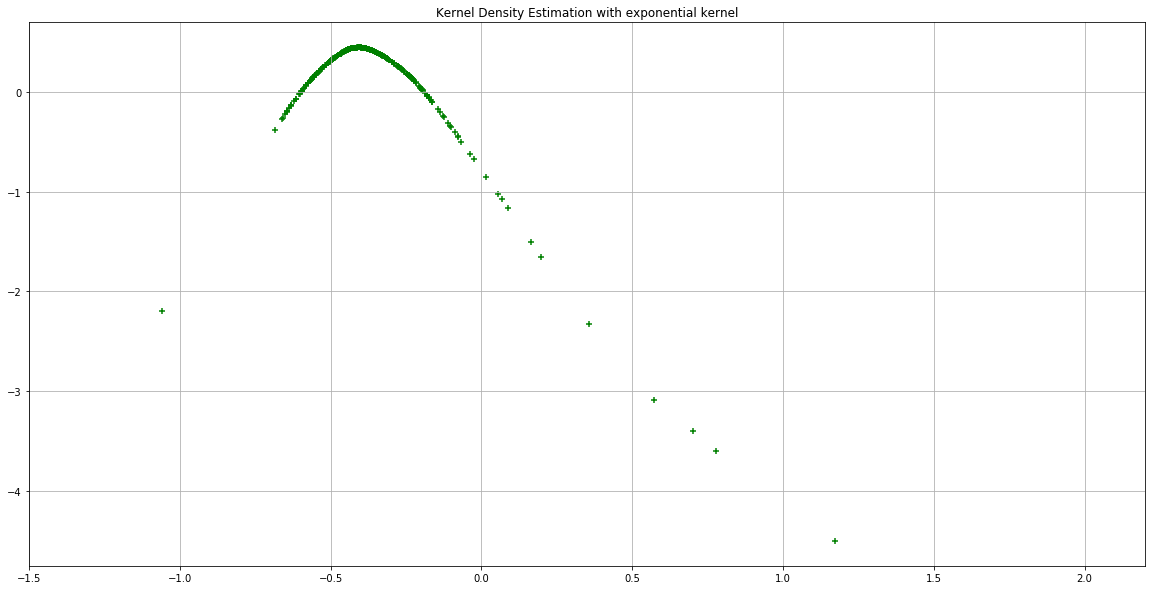

In [20]:
kdegraph('exponential')

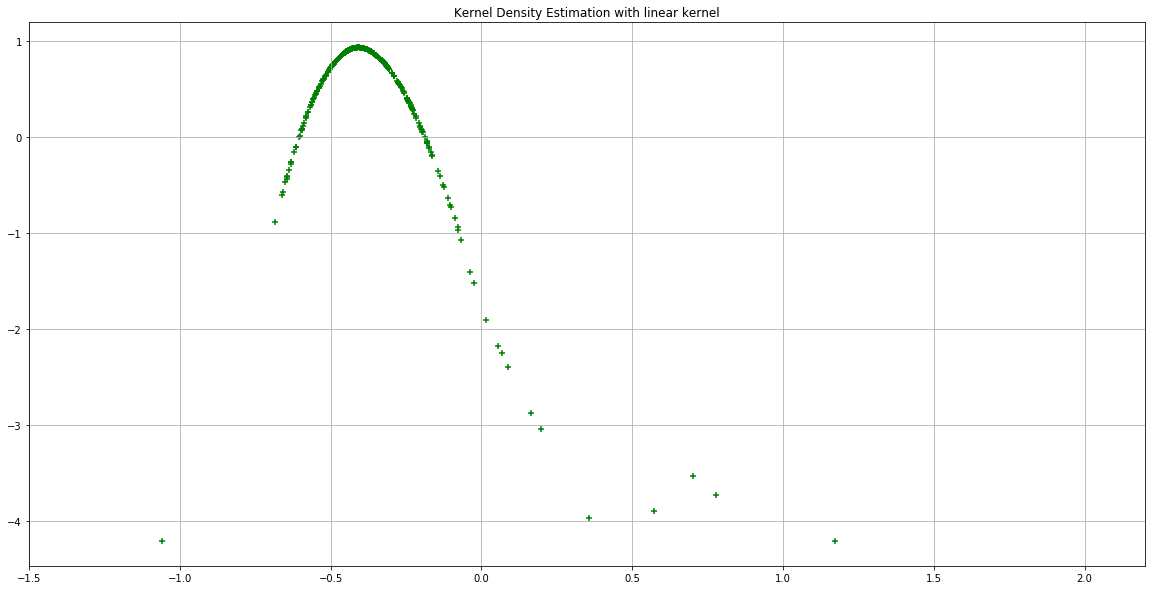

In [21]:
kdegraph('linear')

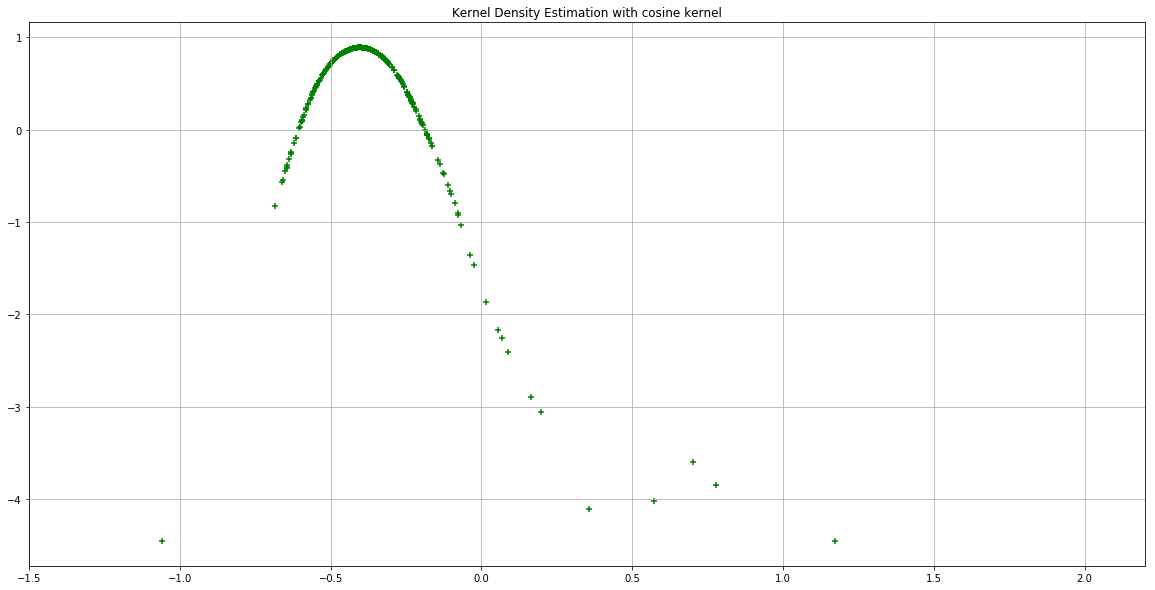

In [22]:
kdegraph('cosine')

Sampling for the epanechnikov, linear and cosine kernels isn't implemented in sklearn. However, the tophat kernel seems good enough when compared to the empirical cumulative distribution function.

<a id='switching'></a>
# Switching Model Regression

##  Utils

In [23]:
def plot_regression(estimator, X_train, y_train, X_test, y_test):
    x_axis = np.linspace(0, 64, 10000).reshape((10000, 1))
    y_axis = estimator.predict(x_axis)
    plt.figure(figsize=(20, 10))
    plt.grid()
    plt.xlim(-1, 64)
    plt.ylim(-2, 5)
    plt.title('Wealth prediction according to nightlight intensity')
    plt.xlabel('nightlight intensity')
    plt.ylabel('wealth')
    plt.scatter(X_train, y_train)
    plt.scatter(X_test, y_test, color='r')
    plt.plot(x_axis, y_axis)
    plt.show()

In [24]:
def plot_mse(class_estimator, alpha_min, alpha_max, precision, X_train, y_train, X_test, y_test):
    alpha_list = np.linspace(alpha_min, alpha_max, precision)
    train_MSE = []
    test_MSE = []
    for alpha in alpha_list:
        estimator = class_estimator(int(alpha))
        estimator.train(X_train, y_train)
        train_MSE.append(estimator.train_MSE)
        test_MSE.append(np.linalg.norm(y_test - estimator.predict(X_test)) / y_test.shape[0])
    plt.plot(alpha_list, test_MSE, color='red')
    plt.plot(alpha_list, train_MSE, color='green')
    plt.xlabel('hyperparameter')
    plt.ylabel('MSE')
    plt.grid()
    plt.show()

## Model

The first regime is chosen as the tophat kernel density estimation, and some models are compared in order to chose the second regime.

In [25]:
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.20, random_state=42)
y_low_train, y_low_test = train_test_split(y_low, test_size=0.20, random_state=42)

y_train = np.concatenate((y_low_train, y_high_train))
y_test = np.concatenate((y_low_test, y_high_test))

In [26]:
class LinearRegression:
    
    def __init__(self):
        self.coeff = None
        self.train_MSE = None
        
    def train(self, X_train, y_train):
        intercept = np.ones((X_train.shape[0], 1))
        X = np.append(intercept, X_train, axis=1)
        beta = scipy.linalg.solve(np.dot(X.T, X), np.dot(X.T, y_train))
        self.coeff = beta
        self.train_MSE = np.linalg.norm(y_train - self.predict(X_train)) / y_train.shape[0]
    
    def predict(self, X_test):
        intercept = np.ones((X_test.shape[0], 1))
        X = np.append(intercept, X_test, axis=1)
        y_test = np.dot(X, self.coeff)
        return y_test

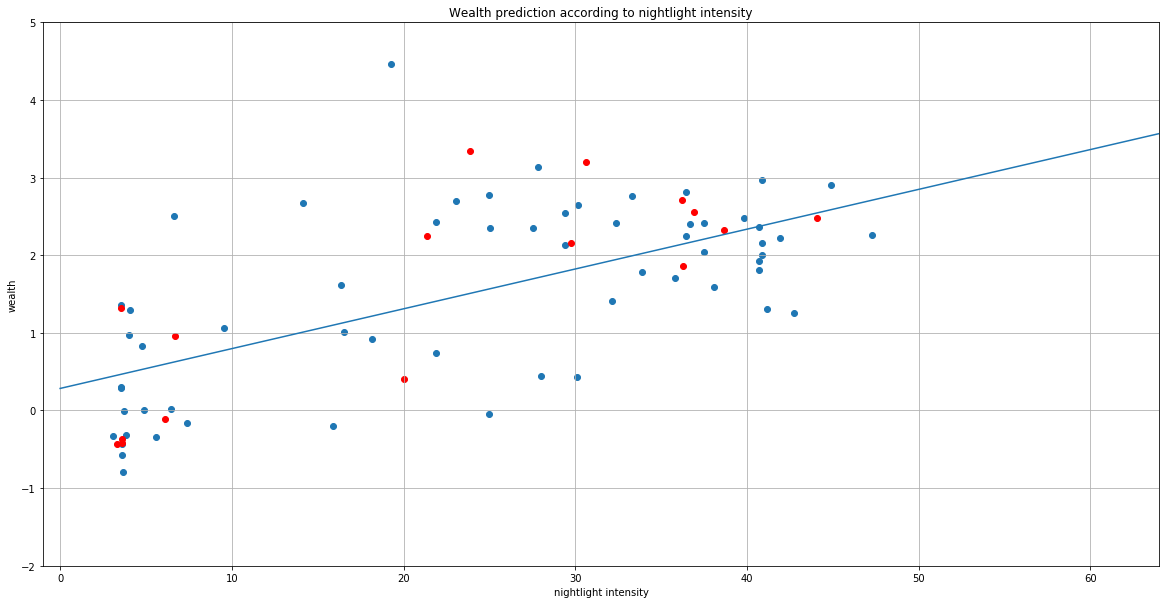

MSE on train data : 0.11669508435212914
MSE on test data : 0.20763915969383417


In [27]:
estimator = LinearRegression()
estimator.train(X_high_train, y_high_train)

plot_regression(estimator, X_high_train, y_high_train, X_high_test, y_high_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.linalg.norm(y_high_test - estimator.predict(X_high_test)) / y_high_test.shape[0])

In [28]:
class KernelSmoothing:
    
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
        self.X = None
        self.y = None
        self.train_MSE = None
        
    def kernel(self, x, y):
        return (1 / np.sqrt(2*np.pi)) * np.exp(- 0.5 * np.linalg.norm(x - y)**2 / self.bandwidth**2)
    
    def train(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
        self.train_MSE = np.linalg.norm(y_train - self.predict(X_train)) / y_train.shape[0]
        
    def predict(self, X_test):
        y_test = []
        for x_test in X_test:
            W = [self.kernel(x_test, self.X[i]) for i in range(self.X.shape[0])]
            res = np.dot(W, self.y) / np.sum(W)
            y_test.append(res)
        y_test = np.array(y_test)
        return y_test

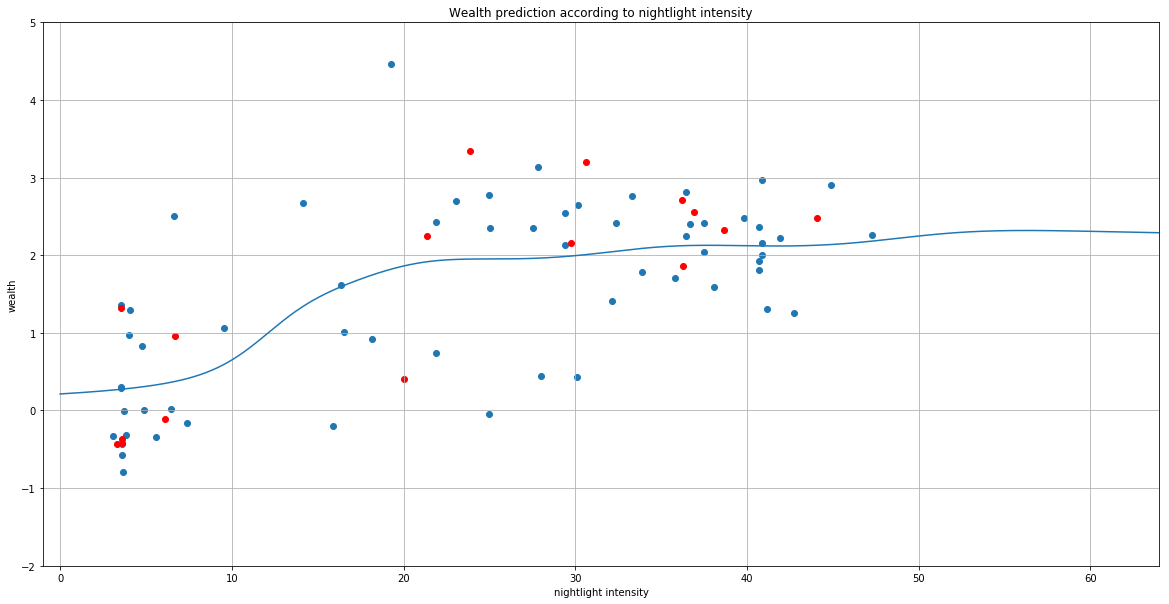

MSE on train data : 0.11067205856027827
MSE on test data : 0.1918234881300694


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


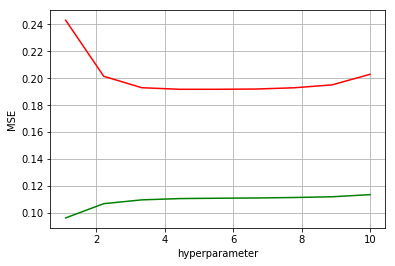

In [29]:
estimator = KernelSmoothing(4)
estimator.train(X_high_train, y_high_train)

plot_regression(estimator, X_high_train, y_high_train, X_high_test, y_high_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.linalg.norm(y_high_test - estimator.predict(X_high_test)) / y_high_test.shape[0])

plot_mse(KernelSmoothing, 0, 10, 10, X_high_train, y_high_train, X_high_test, y_high_test)

In [30]:
class RidgeRegression:
    
    def __init__(self, gamma):
        self.coeff = None
        self.gamma = gamma
        self.train_MSE = None
        
    def train(self, X_train, y_train):        
        intercept = np.ones((X_train.shape[0], 1))
        X = np.append(intercept, X_train, axis=1)
        beta = scipy.linalg.solve(np.dot(X.T, X) + self.gamma * np.identity(X.shape[1]), np.dot(X.T, y_train))
        #beta = np.dot(X.T, np.linalg.inv(np.dot(X, X.T) + gamma * np.identity(X.shape[0])).dot(y_train))
        self.coeff = beta
        self.train_MSE = np.linalg.norm(y_train - self.predict(X_train)) / y_train.shape[0]
    
    def predict(self, X_test):
        intercept = np.ones((X_test.shape[0], 1))
        X = np.append(intercept, X_test, axis=1)
        y_test = np.dot(X, self.coeff)
        return y_test

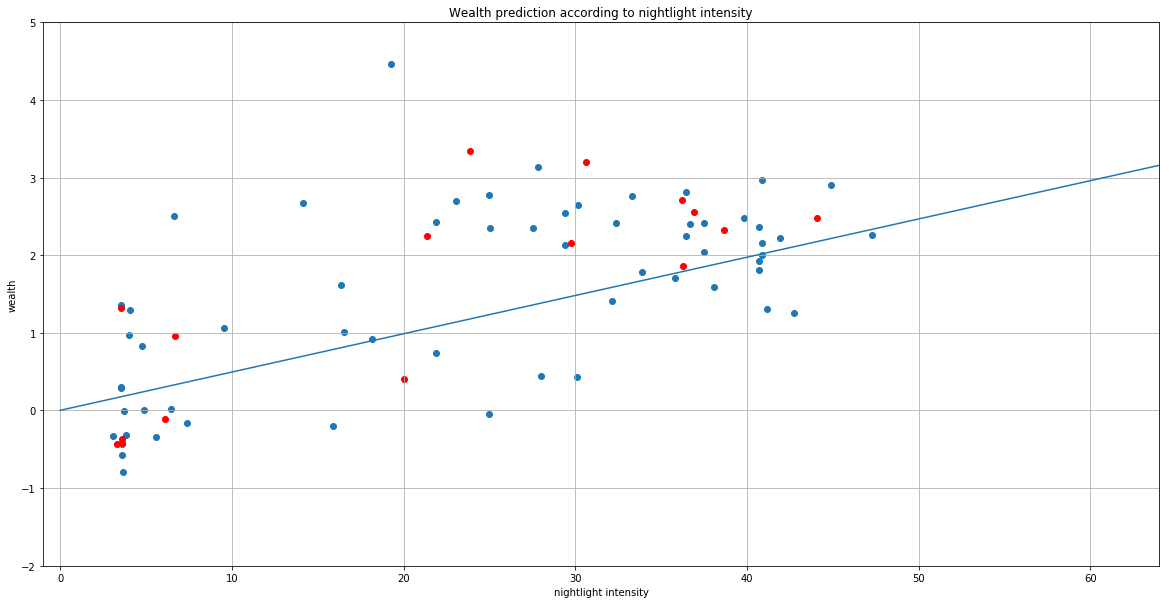

MSE on train data : 0.12423259025488015
MSE on test data : 0.23638330100896413


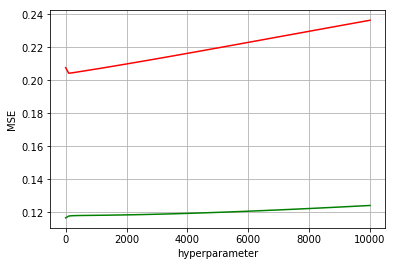

In [31]:
estimator = RidgeRegression(gamma=1e4)
estimator.train(X_high_train, y_high_train)

plot_regression(estimator, X_high_train, y_high_train, X_high_test, y_high_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.linalg.norm(y_high_test - estimator.predict(X_high_test)) / y_high_test.shape[0])

plot_mse(RidgeRegression, 0, 1e4, 100, X_high_train, y_high_train, X_high_test, y_high_test)

The kernel smoothing model seems to be the best model for the second regime.

## Full model

In [32]:
class SwitchingModel:
    
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
        self.X_high = None
        self.y_high = None
        self.y_low = None
        self.train_MSE = None
        self.kde = None
        
    def kernel(self, x, y):
        return (1 / np.sqrt(2*np.pi)) * np.exp(- 0.5 * np.linalg.norm(x - y)**2 / self.bandwidth**2)
    
    def train(self, X_high_train, y_high_train, y_low_train):
        self.X_high = X_high_train
        self.y_high = y_high_train
        self.y_low = y_low_train
        self.kde = KernelDensity(kernel="tophat", bandwidth=0.2).fit(self.y_low)
        self.train_MSE = np.linalg.norm(y_train - self.predict(X_high_train, y_low_train)) / y_train.shape[0]
        
    def predict(self, X_high_test, y_low_test):
        y_test = []
        for x in self.kde.sample(np.shape(y_low_test)[0]):
            y_test.append(x)
        for x_test in X_high_test:
            W = [self.kernel(x_test, self.X_high[i]) for i in range(self.X_high.shape[0])]
            res = np.dot(W, self.y_high) / np.sum(W)
            y_test.append(res)
        y_test = np.array(y_test)
        return y_test

In [33]:
estimator = SwitchingModel(4)
estimator.train(X_high_train, y_high_train, y_low_train)

mean_mse = 0
for i in range(100):
    mean_mse += np.linalg.norm(y_test - estimator.predict(X_high_test, y_low_test)) / y_test.shape[0]

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', mean_mse / 100)

MSE on train data : 0.06333739794478897
MSE on test data : 0.11782118906206565


# Source

Statistique avancée : méthodes non-paramétriques
http://imagine.enpc.fr/~dalalyan/Download/poly.pdf